In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

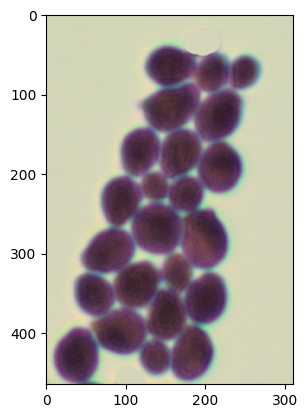

In [2]:
image_name = "./dataset/png/Candida.albicans_0017.png"
image = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
plt.imshow(image)

* K-means clustering

Ref: https://machinelearningknowledge.ai/image-segmentation-in-python-opencv/ \
Doc K-means: https://docs.opencv.org/3.4/d1/d5c/tutorial_py_kmeans_opencv.html

In [3]:
#Target class number
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3 #Trying to find BG / general contours / bacteria
attempts = 10

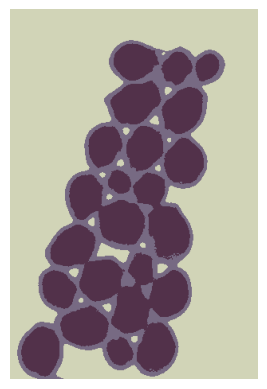

In [4]:
image_as_array = np.float32(image.reshape((-1,3)))

compactness, label, center = cv2.kmeans(image_as_array, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((image.shape))

plt.axis('off')
plt.imshow(result_image)

In [5]:
from cv2 import Mat

def execute_kmeans(image: Mat) -> Mat:
    image_as_array = np.float32(image.reshape((-1,3)))

    _, label, center = cv2.kmeans(image_as_array, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((image.shape))

    return result_image

Remove ""noise"" between bacterias by detecting and suppressing middle channel

Centers found: 
[[ 82  49  74]
 [209 212 183]
 [119 105 130]]
Averages found: [68.33333333333333, 201.33333333333334, 118.0]
Detected center indexes: min=0, med=2, max=1


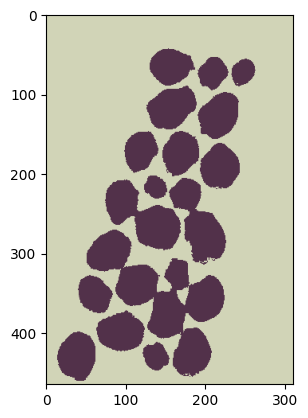

In [6]:
working_image = image.copy()

image_as_array = np.float32(working_image.reshape((-1,3)))

_, label, center = cv2.kmeans(image_as_array, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)

averages = [np.mean(c) for c in center]

print(f"Centers found: \n{center}")
print(f"Averages found: {averages}")

min_index = np.argmin(averages)
max_index = np.argmax(averages)
med_index = list(set((0,1,2)) - set((min_index, max_index)))[0]

print(f"Detected center indexes: min={min_index}, med={med_index}, max={max_index}")

#Suppress medium center directly in center array
center[med_index] = center[max_index] #Replace by background

res = center[label.flatten()]
suppressed_image = res.reshape((image.shape))
plt.imshow(suppressed_image)

Trivial binarization

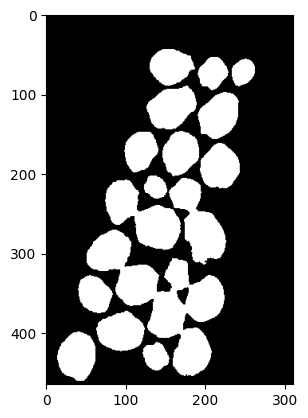

In [7]:
gray_image = cv2.cvtColor(suppressed_image, cv2.COLOR_RGB2GRAY)
gray_image = cv2.GaussianBlur(gray_image, (5,5), 0)
_, binarized_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(binarized_image, cmap='gray', vmin=0, vmax=255)

Morphological

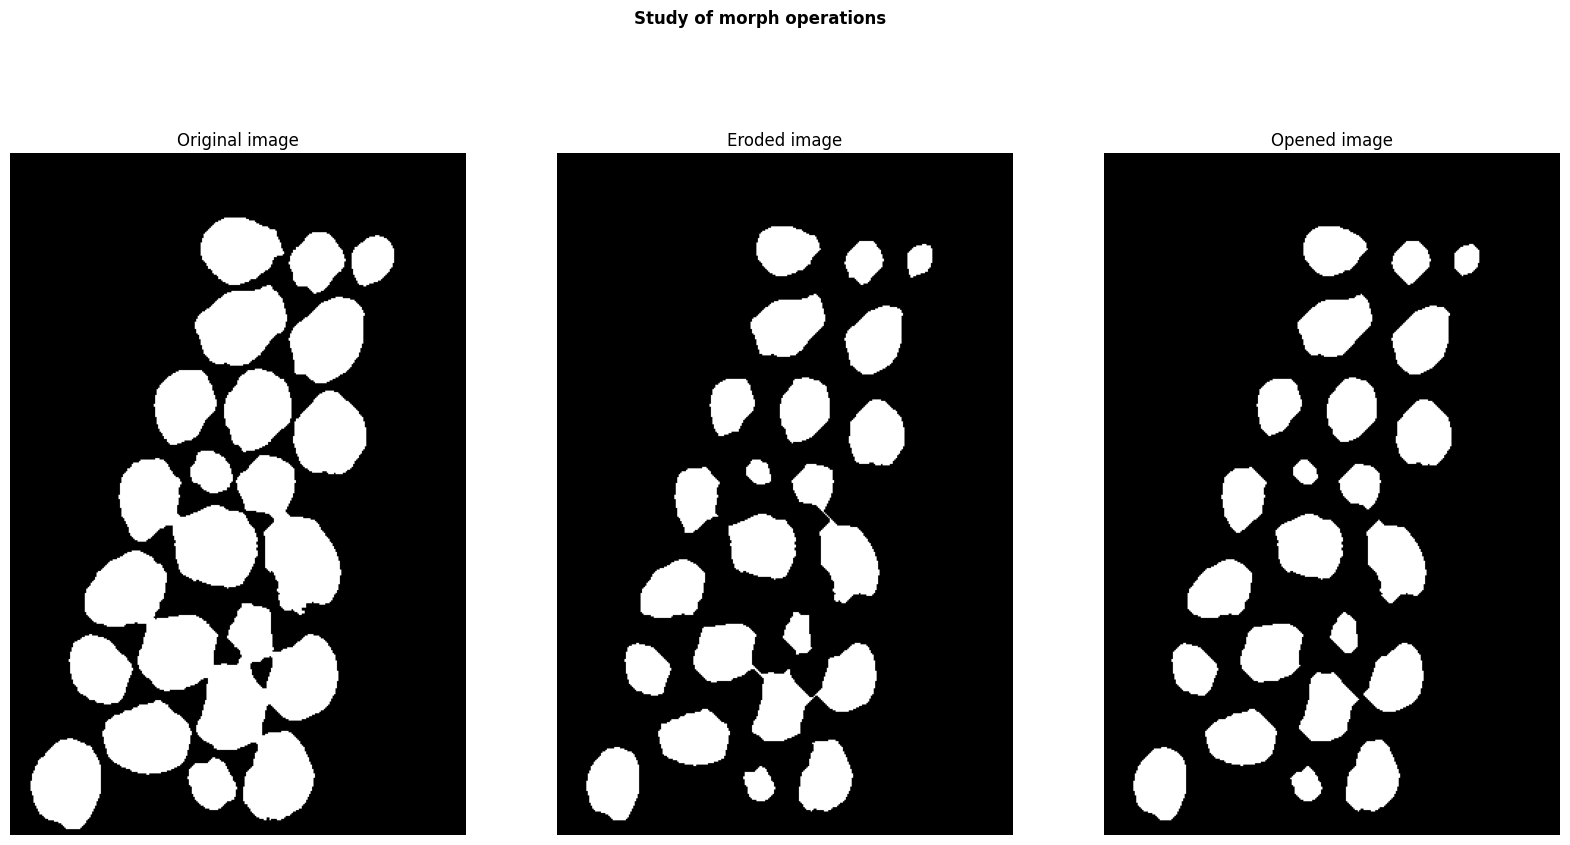

In [8]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
eroded_image = cv2.morphologyEx(binarized_image, cv2.MORPH_ERODE, kernel, iterations=6)
open_image = cv2.morphologyEx(eroded_image, cv2.MORPH_OPEN, kernel, iterations=4)

fig, ax = plt.subplots(1, 3, figsize=(20,10))
fig.suptitle(f'Study of morph operations', fontweight='bold')

ax[0].imshow(binarized_image, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original image')
ax[0].set_axis_off()

ax[1].imshow(eroded_image, cmap='gray', vmin=0, vmax=255)
ax[1].set_title('Eroded image')
ax[1].set_axis_off()

ax[2].imshow(open_image, cmap='gray', vmin=0, vmax=255)
ax[2].set_title('Opened image')
ax[2].set_axis_off()

final_morphed_image = open_image

Edge detection

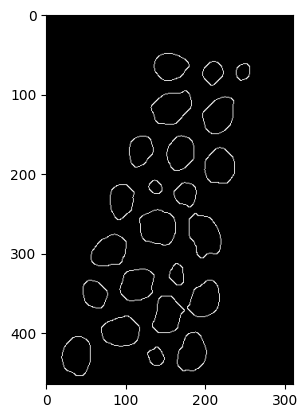

In [9]:
img_blur = cv2.GaussianBlur(final_morphed_image, (3,3), 0)
canny_img = cv2.Canny(img_blur, 0, 255)

plt.imshow(canny_img, cmap='gray', vmin=0, vmax=255)

Blob detection

In [10]:
params = cv2.SimpleBlobDetector_Params()

params.filterByArea=True
params.minArea=1

params.filterByCircularity=True
params.minCircularity=0.2

params.filterByConvexity=True
params.minConvexity = 0.2

params.filterByInertia=True
params.minInertiaRatio=0.01

detector=cv2.SimpleBlobDetector_create(params)

Found 1 blobs


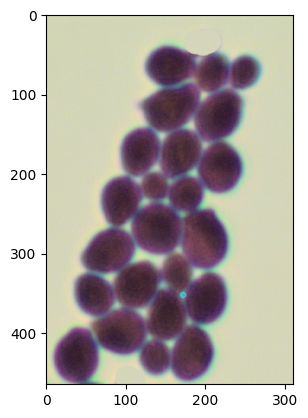

In [11]:
image_copy = image.copy()

keypoints= detector.detect(binarized_image)

#cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensure the
#size of circle corresponds to the size of blob
blank = np.zeros((1,1))
blobs = cv2.drawKeypoints(image_copy,keypoints,blank,(0,255,255),cv2.DRAW_MATCHES_FLAGS_DEFAULT)

print(f"Found {len(keypoints)} blobs")

plt.imshow(blobs)

Found 0 blobs


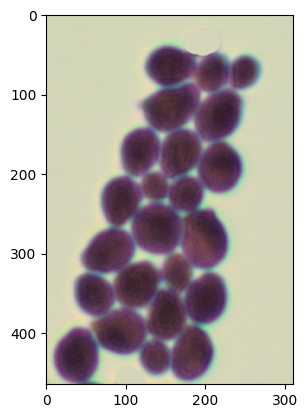

In [12]:
image_copy = image.copy()

keypoints= detector.detect(eroded_image)

#cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensure the
#size of circle corresponds to the size of blob
blank = np.zeros((1,1))
blobs = cv2.drawKeypoints(image,keypoints,blank,(0,255,255),cv2.DRAW_MATCHES_FLAGS_DEFAULT)

print(f"Found {len(keypoints)} blobs")

plt.imshow(blobs)


Found 0 blobs


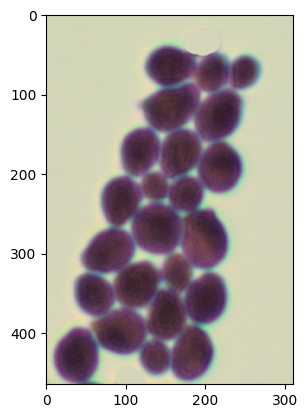

In [13]:
image_copy = image.copy()

keypoints= detector.detect(open_image)

#cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensure the
#size of circle corresponds to the size of blob
blank = np.zeros((1,1))
blobs = cv2.drawKeypoints(image,keypoints,blank,(0,255,255),cv2.DRAW_MATCHES_FLAGS_DEFAULT)

print(f"Found {len(keypoints)} blobs")

plt.imshow(blobs)

Found 0 blobs


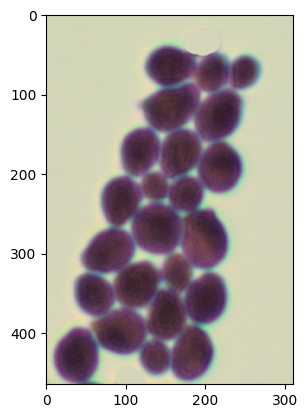

In [14]:
image_copy = image.copy()

keypoints= detector.detect(final_morphed_image)

#cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensure the
#size of circle corresponds to the size of blob
blank = np.zeros((1,1))
blobs = cv2.drawKeypoints(image,keypoints,blank,(0,255,255),cv2.DRAW_MATCHES_FLAGS_DEFAULT)

print(f"Found {len(keypoints)} blobs")

plt.imshow(blobs)

Found 23 blobs


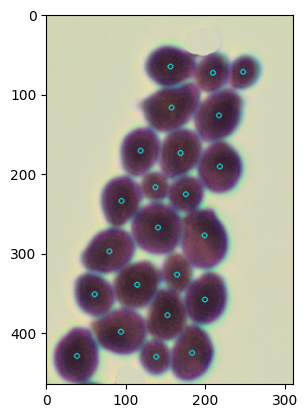

In [15]:
image_copy = image.copy()

keypoints= detector.detect(canny_img)

#cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensure the
#size of circle corresponds to the size of blob
blank = np.zeros((1,1))
blobs = cv2.drawKeypoints(image,keypoints,blank,(0,255,255),cv2.DRAW_MATCHES_FLAGS_DEFAULT)

print(f"Found {len(keypoints)} blobs")

plt.imshow(blobs)